In [1]:
import nanooptics.photophysics as pp
import numpy as np
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

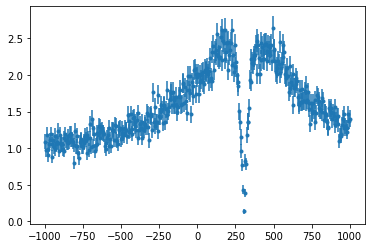

In [2]:
# generate monte carlo data for a simple 3 level system

N = 100000
t_excite = 50
t_radiative_decay = 200
t_shelving = 400
t_deshelving = 1000
dead_time = 0
offset = 300

excite_delays = np.random.exponential(t_excite, N)
radiative_delays = np.random.exponential(t_radiative_decay, N)
shelving_delays = np.random.exponential(t_shelving, N)
deshelving_delays = np.random.exponential(t_deshelving, N)

photon_emitted = radiative_delays < shelving_delays

delays = excite_delays + np.choose(
    photon_emitted,
    [shelving_delays + deshelving_delays, radiative_delays]
)
        
detection_times = np.cumsum(delays)[photon_emitted]
channel = np.random.randint(2, size=len(detection_times))

last_t2_index = len(detection_times)
mask = np.ones(last_t2_index, dtype=np.bool)

for i in range(last_t2_index):
        if mask[i]:
            if channel[i] == 0:
                for j in range(i+1, last_t2_index):
                    tau = (detection_times[j] - detection_times[i])
                    if tau > dead_time:
                        break
                    if channel[j] == 0:
                        mask[j] = False
            elif channel[i] == 1:
                for j in range(i+1, last_t2_index):
                    tau = (detection_times[j] - detection_times[i])
                    if tau > dead_time:
                        break
                    if channel[j] == 1:
                        mask[j] = False

channel = channel[mask]
detection_times = detection_times[mask]
detection_times[channel == 1] = detection_times[channel == 1] + offset
idx_array = np.argsort(detection_times)
detection_times = detection_times[idx_array]
channel = channel[idx_array]

result = pp.cycorr.corr(channel,
                        detection_times, 
                        cutofftime=1000,
                        resolution=5, chan0=0, chan1=1)
plt.errorbar(result.tau, result.g2, result.yerr, fmt='.')

[[Model]]
    Model(g2_wrapped)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 400
    # variables        = 5
    chi-square         = 420.235581
    reduced chi-square = 1.06388755
    Akaike info crit   = 29.7403652
    Bayesian info crit = 49.6976879
[[Variables]]
    tau0:         305.595539 +/- 0.42021237 (0.14%) (init = 300)
    bgfactor:     0.05159388 +/- 0.02042175 (39.58%) (init = 0.1)
    t_antibunch:  40.6407788 +/- 1.71517267 (4.22%) (init = 200)
    A_0:          2.43855711 +/- 0.12837556 (5.26%) (init = 2)
    t_0:          344.472239 +/- 8.45296804 (2.45%) (init = 1000)
    g2_0:         0.09571796 +/- 0.03512197 (36.69%) == '( bgfactor**2 + 2*bgfactor ) / ( 1 + bgfactor )**2'
[[Correlations]] (unreported correlations are < 0.100)
    C(bgfactor, A_0)         =  0.867
    C(t_antibunch, A_0)      =  0.807
    C(t_antibunch, t_0)      = -0.645
    C(A_0, t_0)              = -0.608
    C(bgfactor, t_antibunch) =  0

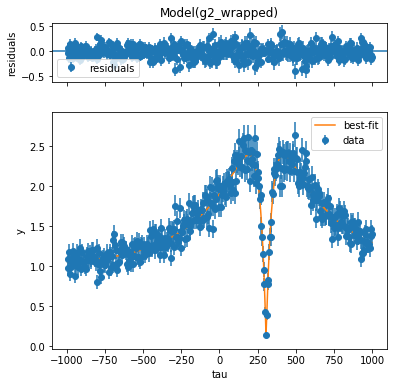

In [3]:
res = pp.fit_g2(result.tau, result.g2,  result.yerr,
                tau0=offset, t_antibunch=t_radiative_decay,
                t_bunch=[t_deshelving],
                a_bunch=[2])
res.plot()
print(res.fit_report())